In [92]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer

In [93]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siapatodia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [94]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPT not available, CPU used")

GPT not available, CPU used


In [95]:
# cd sample_data

In [96]:
# load data
df = pd.read_csv("../input/mbti_1.csv")
df.info()
print("\n")

# Check null values
print("Count for null values")
print(df[df.isnull()].count())

print("\n")

def get_post(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))
posts = []
df.apply(lambda x: get_post(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))

df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


Count for null values
type     0
posts    0
dtype: int64




/var/folders/4m/wpkqt85d6pb02y39qgck06g40000gn/T/ipykernel_66050/1992408240.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for post in posts[1].split("|||"):
/var/folders/4m/wpkqt85d6pb02y39qgck06g40000gn/T/ipykernel_66050/1992408240.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_posts.append((posts[0], post))


Number of users 8675
Number of posts 422845


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [97]:
# Data processing
def process(df, remove_special=True):
    # Change to lowercase
    df['posts'] = df['posts'].apply(lambda x: x.lower())

    #Change case => lowercase - alternative method to change case
    #df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove acronyms of personality types within text, for accrate prediction with unknown data
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    #Substitute hyperlinks with space
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https', '', x.replace("|"," ") + " "))

    # Substitute punctuations except EOS characters
        #Substitute all punctuation except EOS characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))  #remove punctuation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))  #avoid multiple full stops

    #Remove Numeric + Spl chars
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Remove multiple letters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x))

    #Keep words within acceptable range (min letter 3, max 30)
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))
    return df

#Call function on data set
df = process(df, remove_special=True)
print(df.shape)
print(df.head())


(8675, 2)
   type                                              posts
0  INFJ      enfp  intj moments   sportscenter    plays...
1  ENTP   finding  lack    these posts very alarming EO...
2  INTP  good         course  which    know thats  bles...
3  INTJ  dear intp    enjoyed  conversation  other  EOS...
4  ENTJ  youre fired EOSTokenDot    thats another silly...


In [98]:
#Set benchmark for comments/posts - minimum length
min_w = 10
print ("All posts :", df.shape[0])
df['Words'] = df['posts'].apply(lambda x: len(re.findall(r'\w+',x)))
df = df[df['Words'] >= min_w]
print ("Benchmarked posts :", df.shape[0])
print()

df.head()

All posts : 8675
Benchmarked posts : 8504



,type,posts,Words
0,INFJ,enfp intj moments sportscenter plays...,430
1,ENTP,finding lack these posts very alarming EO...,803
2,INTP,good course which know thats bles...,253
3,INTJ,dear intp enjoyed conversation other EOS...,777
4,ENTJ,youre fired EOSTokenDot thats another silly...,402


In [99]:
# # Label encoding - convert personality type into numerical form
# enc = LabelEncoder()
# df["type of encoding"] = enc.fit_transform(df['type'])
# target = df['type of encoding']
# df.head(10)

In [100]:
X, y = df['posts'].values, df['type'].values

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(f"Shape of train data is {X_train.shape}")
print(f"Shape of test data is {X_test.shape}")

Shape of train data is (6378,)
Shape of test data is (2126,)


In [102]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6378,), (6378,), (2126,), (2126,))

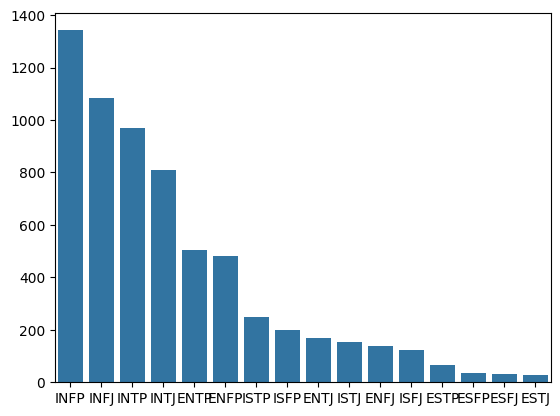

In [103]:
# Analyze distribution of types
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']), y=dd.values)
plt.show()

In [83]:
'''def tockenize(X_train, y_train, X_val, y_val):
    word_list = []
    stop_words = set(stopwords.words('english'))
    labels = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,
              'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,
              'ESFJ' ,'ESTJ']
    for sent in X_train:
        for word in sent.lower().split():
            # word = process_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w: i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train, final_list_test = [], []
    for sent in X_train:
        final_list_train.append([onehot_dict[word] for word in sent.lower().split()
                                if word in onehot_dict.keys()])

    for sent in X_val:
        final_list_test.append([onehot_dict[word] for word in sent.lower().split()
                                if word in onehot_dict.keys()])
    encoded_train = [labels.index(label) for label in y_train]
    encoded_test = [labels.index(label) for label in y_val]
    return np.array(final_list_train,dtype='O'), np.array(encoded_train,dtype='O'), np.array(final_list_test,dtype='O'), np.array(encoded_test,dtype='O'), onehot_dict'''

In [104]:
def tokenize(X_train, y_train, X_val, y_val):
    # Initialize the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize input texts
    encoded_train = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt", max_length=1000)
    encoded_val = tokenizer(X_val, padding=True, truncation=True, return_tensors="pt", max_length=1000)

    # Convert labels to indices
    labels = ['INFP', 'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP',
              'ISFP', 'ENTJ', 'ISTJ', 'ENFJ', 'ISFJ', 'ESTP', 'ESFP',
              'ESFJ', 'ESTJ']
    encoded_train_labels = torch.tensor([labels.index(label) for label in y_train], dtype='O')
    encoded_val_labels = torch.tensor([labels.index(label) for label in y_val], dtype='O')

    return encoded_train['input_ids'], encoded_train_labels, encoded_val['input_ids'], encoded_val_labels, tokenizer.get_vocab()

In [105]:
X_train, y_train, X_test, y_test, vocab = tockenize(X_train, y_train, X_test, y_test)

In [106]:
# Padding
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [107]:
# We have very less number of reviews with length > 500.
# So we will consider only below it
X_train_pad = padding_(X_train, 500)
X_test_pad = padding_(X_test, 500)

In [108]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [109]:
# Batching and loading as tensor
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [110]:
# obtain one batch of training data
detaiter = iter(train_loader)
sample_X, sample_y = next(detaiter)

print("Sample input size: ", sample_X.size()) # batch_size, seq_size
print("Sample input: \n", sample_X)
print("Sample Output: \n", sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[ 10, 179,  42,  ...,   1,  73, 382],
        [742,  79,  36,  ..., 310, 489,  74],
        [ 78,   2, 416,  ...,   1, 104, 577],
        ...,
        [  0,   0,   0,  ..., 972,  41, 181],
        [  8,  29, 955,  ...,  93,   1,   1],
        [ 88, 413,  87,  ...,   1,  34,  13]])
Sample Output: 
 tensor([ 6,  0,  2, 11,  1,  6,  1,  7, 10,  3, 12,  2,  3,  4,  3,  4,  0,  2,
         1,  4,  8,  0,  2,  1,  1,  5,  1,  9,  3,  0,  5,  1,  0,  2, 10,  1,
         1, 11,  3,  2,  8,  9,  3,  2,  3,  2,  4,  0,  5,  5])


In [111]:
# Model
class MBTIRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5):
        super(MBTIRNN, self).__init__()
        self.output_dim = 1
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # lstm
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim,
                            num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x) # Shape: B x S x Feature since batch = True
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [112]:
no_layers = 2
vocab_size = len(vocab) + 1 # extra 1 for padding
embedding_dim = 80
output_dim = 1
hidden_dim = 256

model = MBTIRNN(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5)

model.to(device)

print(model)

MBTIRNN(
  (embedding): Embedding(1001, 80)
  (lstm): LSTM(80, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [113]:
# loss and optimization functions
lr = 0.005

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [114]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden srate
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculate accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs/LSTMs
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    with torch.inference_mode():
      for input, labels in valid_loader:
          val_h = tuple([each.data for each in val_h])
          inputs, labels = inputs.to(device), labels.to(device)

          output, val_h = model(inputs, val_h)
          val_loss = criterion(output.squeeze(), labels.float())
          val_losses.append(val_loss.item())

          accuracy = acc(output, labels)
          val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f"Epoch {epoch + 1}")
    print(f"train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}")
    print(f"train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc}")
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../models/state_dict.pt')
        print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...".format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*"==")

/var/folders/4m/wpkqt85d6pb02y39qgck06g40000gn/T/ipykernel_66050/3019054020.py:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), clip)


Epoch 1
train_loss : 623.5799183282327 val_loss : 623.688244774228
train_accuracy : 17.293822514894952 val_accuracy : 0.16839134524929444
Validation loss decreased (inf --> 623.688245). Saving model ...
Epoch 2
train_loss : 623.1568860632228 val_loss : 624.61965070452
train_accuracy : 16.933207902163687 val_accuracy : 0.16792097836312322


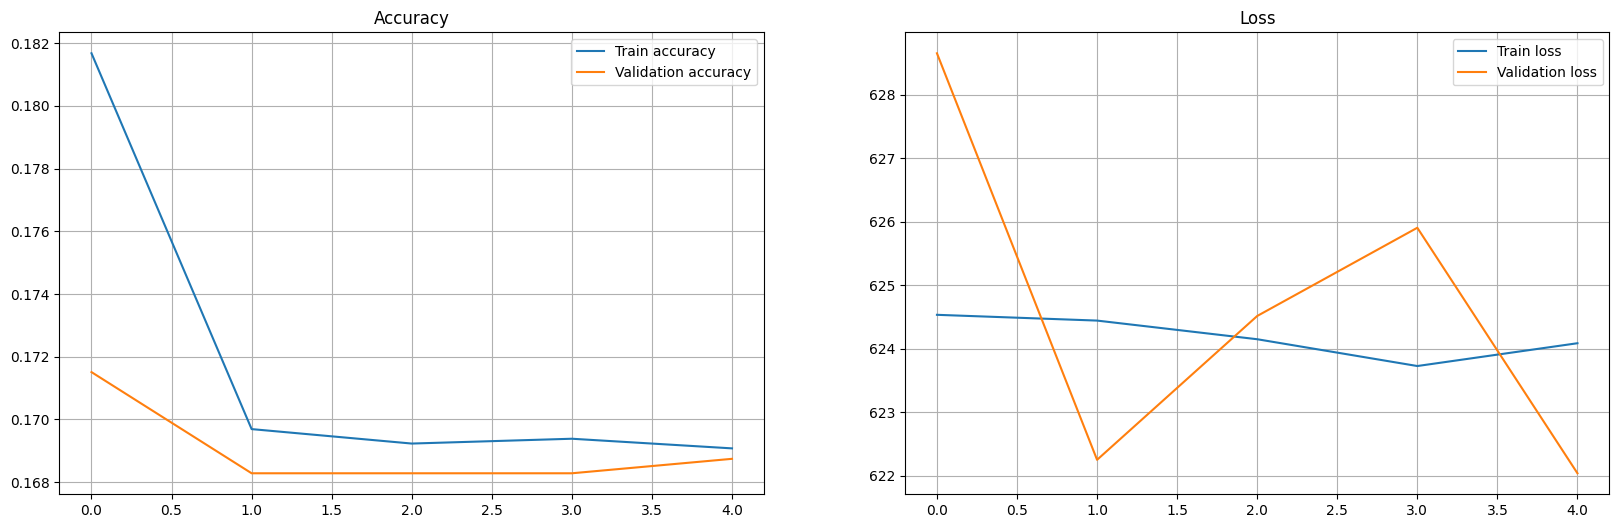

In [ ]:
fit = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label="Train accuracy")
plt.plot(epoch_vl_acc, label="Validation accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label="Train loss")
plt.plot(epoch_vl_loss, label="Validation loss")
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()